# Brand analysis notebook

In [1]:
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
import json
import seaborn as sns
import bisect
from IPython.display import IFrame
%matplotlib inline

In [2]:
import findspark
findspark.init()

import pyspark
conf = pyspark.SparkConf()\
    .setMaster('local[*]')\
    .set('spark.executor.memory', '1g')\
    .set('spark.driver.memory', '1g')\
    .set('spark.executor.instances', '4')
    
sc = pyspark.SparkContext(conf=conf)

### Test and example

##### @todo: why do I need to run it twice?

In [3]:
# New dataset format. salesRankCat and salesRankPos are always included together
sc.textFile('data/reduced.json')\
    .map(lambda x: json.loads(x))\
    .filter(lambda x: 'price' in x and 'salesRankCat' in x)\
    .take(1)

[{'asin': '9868238854',
  'average_rating': 5.0,
  'bought_together': [],
  'buy_after_viewing': ['B0002MS7O2',
   'B0002D00QE',
   'B000RW20Q8',
   '0882848143'],
  'category': ['Musical Instruments',
   'Band & Orchestra',
   'Wind & Woodwinds',
   'Recorders'],
  'description': 'Woodnote Tenor Recorder  was made of High performance ABS Plastic Resin and are highly recommended by many buyers and collectors.',
  'helpful_fraction': 1.0,
  'imUrl': 'http://ecx.images-amazon.com/images/I/51h8cIN5FaL._SY300_.jpg',
  'num_reviews': 2,
  'price': 61.41,
  'salesRankCat': 'Musical Instruments',
  'salesRankPos': 60253,
  'title': 'Woodnote Wood Grain Tenor Recorder-Baroque fingering/3 pieces construction'}]

### Load dataset, select category, filter entries

In [122]:
# Collect the products in the "Headphones" category
#cat = ['Electronics', 'Accessories & Supplies', 'Audio & Video Accessories', 'Headphones']
#cat = ['Electronics', 'Camera & Photo', 'Digital Cameras']
#.filter(lambda x: 'salesRankCat' in x and 'price' in x and 'brand' in x and 'related' in x and 'average_rating' in x)\
#cat = ['Electronics']
cat = ['Cell Phones & Accessories', 'Cell Phones']
records = sc.textFile('data/reduced.json')\
    .map(lambda x: json.loads(x))\
    .filter(lambda x: 'price' in x and 'title' in x and 'average_rating' in x and 'num_reviews' in x)\
    .filter(lambda x: len(x['category']) >= len(cat) and x['category'][:len(cat)] == cat)\
    .collect()

### Brand data augmentation and filtering

In [123]:
brands_total = []

for r in records:
    if 'brand' in r:
        if r['brand'] in r['title'] and r['brand'] != 'Generic':
            brands_total.append(r['brand'])

        
brands_total_set = sorted(set(brands_total))
print("There are " + str(len(records)) + " records in category.")
print("There are " + str(len(brands_total_set)) + " brands overall.")

There are 5554 records in category.
There are 74 brands overall.


In [124]:
count = 0
for r in records:
    if 'brand' in r and r['brand'] == 'Generic':
        r['brand'] = ""
    if 'brand' not in r or r['brand'] not in r['title']:
        # find matching brands in title
        matching = [b for b in brands_total_set if b in r['title']]
        # filter null brands ''
        matching = list(filter(lambda x: x != '', matching))
        #print(matching)
        # only a brand should be found in title
        if len(matching) == 1:
            r['brand'] = matching[0]
            count += 1
            
print(count, "brands have been added")

2090 brands have been added


In [125]:
records = list(filter(lambda x: 'brand' in x, records))
print("There are " + str(len(records)) + " records in category.")

There are 3543 records in category.


## NB: Create graph with the following code!

In [126]:
from graph import ProductGraph
g = ProductGraph(records, add_edge_on='buy_after_viewing', remove_edge_on='bought_together')
g = g.drop_singletons()
cliques = g.extract_max_cliques()
len(cliques)

3433

In [127]:
count = 0
dim_cliques = 2
for c in cliques:
    if len(c) < dim_cliques:
        continue
    count += 1
    for i in c:
        print('*',g.records[i]['title'], ' - $', g.records[i]['price'])
    print('------')
    
print("\nThere are", len(g.records), "products.")
print("Total number of cliques:", count)

* Motorola MOTO Q9H SILVER Unlocked Phone with 2MP Camera and Windows Mobile 6.0 - US Warranty  - $ 2.63
* Motorola Q9H Windows 3G GSM Unlocked Black Cell Phone  - $ 3.99
------
* Kyocera Hydro Edge (Boost Mobile)  - $ 64.99
* Kyocera Hydro Prepaid Android Phone (Boost Mobile)  - $ 30.48
------
* BlackBerry 8220 Flip Pearl Unlocked Phone with GPRS, EDGE and 2 MP Camera--U.S. Version with 60 Day Warranty (Black)  - $ 120.0
* BlackBerry 8220 Flip Pearl Unlocked Phone , GPRS, EDGE, and 2 MP Camera--International Version with No Warranty  - $ 101.49
------
* Motorola Droid RAZR HD XT926 16GB LTE 4G Black - Verizon Wireless  - $ 196.5
* Motorola Droid RAZR M XT907 Verizon + GSM Unlocked 4G LTE Android Phone - Black  - $ 151.97
------
* Motorola Droid RAZR HD XT926 16GB LTE 4G Black - Verizon Wireless  - $ 196.5
* Motorola Droid RAZR MAXX 16GB 4G LTE Black Android Smartphone - Verizon  - $ 156.0
* Motorola Droid RAZR MAXX XT912 M Verizon Smartphone (Black/Grey) 4.3 Inches AMOLED Screen  - $ 

------
* Lg optimus E980 international AT&amp;T Unlocked Phone 5.5&quot; Full HD White  - $ 300.0
* LG Optimus G Pro AT&amp;T Unlocked Cell Phone 5.5&quot; FULL HD Model LG-E980 - INDIGO (Dark Blue)  - $ 338.88
------
* Google Nexus 5 Unlocked GSM Phone, 32gb (Red)  - $ 479.98
* LG Nexus 5 D820 16GB Unlocked GSM 4G LTE Quad-Core Android Smartphone w/ 5&quot; True HD IPS+ Multi-Touchscreen - Red  - $ 384.0
------
* HTC One VX AT&amp;T 4G LTE Unlocked GSM Android Smartphone - White  - $ 160.0
* HTC Vivid 4G X710a 16GB AT&amp;T 4G LTE Dual-Core Android Smartphone w/ 8MP Camera - Black  - $ 175.95
------
* HTC One VX AT&amp;T 4G LTE Unlocked GSM Android Smartphone - White  - $ 160.0
* HTC One VX AT&amp;T 4G LTE Unlocked GSM Android Cell Phone - Gray/Red  - $ 174.99
------
* Samsung Galaxy S4 GT-i9500 16GB Factory Unlocked International Verison - Black  - $ 424.97
* Samsung Galaxy S4 i9505 16GB /LTE 800/850/900/1800/2100/2600 Unlocked International Version Black  - $ 457.99
* SAMSUNG GALAXY

* Nokia 6700 Silver  - $ 159.0
* Nokia  6700 Slide Unlocked Phone--US Version with Full Warranty (Silver)  - $ 99.99
------
* Huawei Ascend Y300 - New Unlocked - 3G 850/1900/2100, 4&quot; LCD, 4GB, Android - Smart Phone  - $ 116.55
* Huawei Ascend Y300 GSM Unlocked Google Android SmartphoneY300-0151- Black  - $ 116.99
------
* Nokia 808 PureView Unlocked GSM Phone with Nokia Belle OS, 41MP Camera &amp; Carl Zeiss Optics, GPS, Wi-Fi and Bluetooth - Black  - $ 480.0
* Nokia 808 PureView Unlocked Phone with a 41 MP Camera with Carl Zeiss Optics--U.S. Warranty (White)  - $ 475.0
------
* Motorola RAZR V3 Unlocked Phone with Camera, and Video Player - U.S. Version with Warranty (Black)  - $ 56.75
* Motorola RAZR V3 Unlocked Phone with Camera, and Video Player--U.S. Version with Warranty (Blue)  - $ 67.98
------
* Apple iPhone 5s, Space Gray 16GB (Unlocked)  - $ 664.95
* Apple iPhone 5, Black 16GB (Unlocked)  - $ 518.0
------
* Samsung Galaxy S5 SM-G900H Factory Unlocked- international Versi

### Non-clique analysis

In [128]:
relations = []
for i, a in enumerate(g.records):
    for b_ in a['buy_after_viewing']:
        if b_ not in g.name_id_mapping:
            continue
        j = g.name_id_mapping[b_]
        b = g.records[j]
        if a['asin'] not in b['buy_after_viewing']:
            relations.append([i, j])

Run if you want to analyse non-cliques objects only

In [129]:
cliques = relations

# Brand analysis

##### Brand listing

List all brands

In [130]:
brands_total = []

for r in records:
    if 'brand' in r:
        brands_total.append(r['brand'])
        
brands_total_set = sorted(set(brands_total))
print("There are " + str(len(records)) + " records in category.")
print("There are " + str(len(brands_total_set)) + " brands overall.")
#print(brands_total_set)

There are 3543 records in category.
There are 117 brands overall.


List brands in cliques

In [131]:
brands_in_cliques = []

dimension = 2
for c in cliques:
    if len(c) != dimension:
        continue
    for i in c:
        if 'brand' in g.records[i]:
            brands_in_cliques.append(g.records[i]['brand'])


brands_clique_set= sorted(set(brands_in_cliques))
print(str(len(brands_in_cliques)) + " products in cliques are associated to a brand.")
brands_clique_set = sorted(set(brands_in_cliques))
print("There are " + str(len(brands_clique_set)) + " brands in cliques.")
#print(brands_set)

15918 products in cliques are associated to a brand.
There are 99 brands in cliques.


In [132]:
count = 0
dim_cliques = 2
for c in cliques:
    if len(c) < dim_cliques:
        continue
    count += 1
    for i in c:
        print('*',g.records[i]['title'], ' - $', g.records[i]['brand'])
    print('------')
    
print("\nThere are", len(g.records), "products.")
print("Total number of cliques:", count)

* HTC HD2 T8585 Unlocked Phone with Touch Screen, 5MP Camera, GPS, Wi-Fi and Windows Mobile 6.5 Professional - International Version - Black  - $ HTC
* HTC A9192 Inspire 4G Unlocked Phone with Android OS, 3G Support, 8 MP Camera, Wi-Fi, and GPS--(Black)  - $ HTC
------
* HTC HD2 T8585 Unlocked Phone with Touch Screen, 5MP Camera, GPS, Wi-Fi and Windows Mobile 6.5 Professional - International Version - Black  - $ HTC
* Nokia Lumia 520 8GB Unlocked GSM Windows 8 OS Cell Phone - Black  - $ Nokia
------
* HTC Touch Pro2 T7373 Unlocked Phone with Wifi, GPS and WVGA Display--US Version with Warranty (Brown)  - $ HTC
* Htc Touch Pro 2 T7373 Unlocked GSM Smartphone International Version / Qwerty Keyboard / Touchscreen / 3.5g Quadband  - $ HTC
------
* BlackBerry Curve 8900 Javelin Unlocked Phone with 3.2 MP Camera, gps navigation-International Version with NO US Warranty (Black)  - $ BlackBerry
* BlackBerry Curve 8900 Javelin Unlocked Phone with 3.2 MP Camera, GPS Navigation, Stereo Bluetooth,

* Nokia E51 Unlocked Phone with 2 MP Camera, International 3G, Wi-Fi, MP3/Video Player, and MicroSD Slot--International Version with Warranty (Rose Steel)  - $ Nokia
* Nokia C2-01.5 Unlocked GSM Phone with 3.2 MP Camera and Music and Video Player--U.S. Version with Warranty (Black)  - $ Nokia
------
* Motorola RAZR V3XX Unlocked Phone with 3G, Music/Video Player and MicroSD Slot--International Version with No Warranty--Dark Gray  - $ Motorola
* Motorola RAZR V3xx Unlocked Phone Tri-Band GSM, 3G, with Camera, and Video Player (Gray)  - $ Motorola
------
* Motorola RAZR V3XX Unlocked Phone with 3G, Music/Video Player and MicroSD Slot--International Version with No Warranty--Dark Gray  - $ Motorola
* Motorola RAZR V3xx Unlocked Phone with 3G, MP3/Video Player, and MicroSD Slot--International Version with No Warranty (Licorice Black)  - $ Motorola
------
* Nokia 6700 SLIDE PINK Unlocked Phone  - $ Nokia
* Nokia 6700 Silver  - $ Nokia
------
* Unlocked Samsung i9003 GT-i9003 4GB Galaxy S SC

* BLU Zoey Quadband Unlocked Dual SIM Phone with Camera, Bluetooth and Social Networks  - $ blu
------
* BLU Q170T Samba TV Unlocked Dual SIM Quad-Band GSM Phone (White/blue)  - $ blu
* BLU Zoey Quadband Unlocked Dual SIM Phone with Camera, Bluetooth and Social Networks  - $ blu
------
* HTC One Mini 16GB 4G LTE Unlocked GSM Android Smartphone - Silver  - $ HTC
* HTC ONE Mini M4  - $ HTC
------
* HTC One Mini 16GB 4G LTE Unlocked GSM Android Smartphone - Silver  - $ HTC
* HTC One Mini 16GB 4G LTE Unlocked GSM Android Cell Phone - Silver  - $ HTC
------
* DOOGEE DISCOVERY DG500 5.0&quot; IPS MTK6589 Android 4.2.2 4-Core Phone 1GB RAM 4GB ROM OTG Wireless Display  - $ Doogee
* BLU Studio 5.0 II Unlocked Dual SIM Phone with Dual-Core 1.3GHz Processor, Android 4.2 JB, 4G HSPA+ and 5MP Camera - White  - $ blu
------
* DOOGEE DISCOVERY DG500 5.0&quot; IPS MTK6589 Android 4.2.2 4-Core Phone 1GB RAM 4GB ROM OTG Wireless Display  - $ Doogee
* DOOGEE VOYAGER DG300 5&quot; IPS Capacitive Touch MT

* LG Optimus L7 P705 Black Factory Unlocked  - $ LG
------
* New Factory Unlocked LG Optimus L9 P768 Black International GSM Android Phone HSDPA 900 / 2100 on 3G  - $ LG
* LG Optimus L7 P705 (white) New Internatioanl Unlocked GSM Android Phone  - $ LG
------
* New Factory Unlocked LG Optimus L9 P768 Black International GSM Android Phone HSDPA 900 / 2100 on 3G  - $ LG
* LG OPTIMUS L7 II DUAL P715 Factory Unlocked International Version WHITE  - $ LG
------
* E LV Two Tone Dual Layer Hard Soft High Impact Hybrid Armor Defender Case Combo with Kickstand for Samsung Galaxy S3 Mini i8190 with 1 Black Stylus and E LV Microfiber Digital Cleaner (Samsung Galaxy S3 Mini, Green Pink)  - $ Samsung
* Samsung Galaxy S3 Mini (GT-i8190 / GT-I8200) factory Unlocked International Verison WHITE  - $ Samsung
------
* Samsung Freeform M (Metro PCS)  - $ Samsung
* Huawei Valiant (Metro PCS)  - $ Huawei
------
* Samsung Freeform M (Metro PCS)  - $ Samsung
* Nokia Lumia 521 (Metro PCS)  - $ Nokia
------
* ZTE

* Samsung S5360 Galaxy Y 2MP, 3G, Touchscreen, WIFI, Gingerbread Unlocked World Mobile Phone -Gray  - $ Samsung
* Samsung Galaxy Young S5360 Unlocked GSM Quadband Cell Phone Touch Screen International Version/Warranty Black  - $ Samsung
------
* Samsung S5360 Galaxy Y 2MP, 3G, Touchscreen, WIFI, Gingerbread Unlocked World Mobile Phone -Gray  - $ Samsung
* Samsung Galaxy Y S5360 Black WiFi Android TouchScreen 3G Cell Phone  - $ Samsung
------
* Samsung S5360 Galaxy Y 2MP, 3G, Touchscreen, WIFI, Gingerbread Unlocked World Mobile Phone -Gray  - $ Samsung
* Samsung Galaxy S3 GT-i8190 Mini Blue 8GB factory Unlocked 3G 900/1900/2100  - $ Samsung
------
* Samsung S5360 Galaxy Y 2MP, 3G, Touchscreen, WIFI, Gingerbread Unlocked World Mobile Phone -Gray  - $ Samsung
* Samsung Galaxy Y Duos S6102 Android Dual SIM Quadband Unlocked  - $ Samsung
------
* Motorola Atrix HD MB886 4G LTE Unlocked Android OS Smartphone White  - $ Motorola
* Motorola Atrix 4G MB860 Unlocked GSM Phone with Android 2.2 OS

* Samsung Highlight T749 Cell Phone (Unlocked)  - $ Samsung
* Samsung Solstice II A817 Unlocked GSM Phone with Touchscreen + TouchWiz 2.0 UI, GPS, 2MP Camera, Video, Bluetooth, SNS Integration, MP3/MP4 Player and microSD Slot - Black  - $ Samsung
------
* Samsung Highlight T749 Cell Phone (Unlocked)  - $ Samsung
* LG GT550 Encore Unlocked Phone with 3MP Camera, GPS, 3G Support and Touch Screen - US Warranty - Black  - $ LG
------
* Samsung Freeform III Prepaid Phone (MetroPCS)  - $ Samsung
* Samsung Freeform M (Metro PCS)  - $ Samsung
------
* Samsung Freeform III Prepaid Phone (MetroPCS)  - $ Samsung
* Samsung SCH R360 Samsung Freeform II - Black (Metro PCS) Cellular Phone  - $ Samsung
------
* Samsung Freeform III Prepaid Phone (MetroPCS)  - $ Samsung
* Huawei Pinnacle Prepaid Phone (MetroPCS)  - $ Huawei
------
* Samsung C3222 Ch@t Dual SIM Unlocked GSM Phone with QWERTY Keypad, 1.3 MP Camera, FM Radio and Bluetooth - Unlocked Phone - No Warranty - White  - $ Samsung
* Motorola EX22

* HTC ONE Mini M4  - $ HTC
* HTC ONE M7 32GB 4G LTE Android Smartphone (Unlocked) - Sliver  - $ HTC
------
* LG OPTIMUS ZIP L75C STRAIGHT TALK ANDROID SMARTPHONE CELL PHONE 3.2&quot; TOUCHSCREEN QWERTY KEYBOARD SLIDER  - $ LG
* LG OPTIMUS Q L55C STRAIGHT TALK ANDROID SMARTPHONE CELL PHONE 3.2&quot; TOUCHSCREEN QWERTY KEYBOARD SLIDER  - $ LG
------
* Nokia E50 Unlocked Phone with Camera, MP3/Video Player, and MicroSD Slot--International Version with Warranty (Silver)  - $ Nokia
* Nokia C2-01.5 Unlocked GSM Phone with 3.2 MP Camera and Music and Video Player--U.S. Version with Warranty (Black)  - $ Nokia
------
* Nokia E50 Unlocked Phone with Camera, MP3/Video Player, and MicroSD Slot--International Version with Warranty (Silver)  - $ Nokia
* Nokia X3-02 Unlocked Touch and Type GSM Phone with 5 MP Camera--U.S. Version with Warranty (Metal)  - $ Nokia
------
* Palm Centro Red Smartphone - Sprint  - $ Palm
* Palm Treo 800w Sprint  - $ Palm
------
* 5.3 Inch Capacitance Touch Screen I9220hd

* 8330 BlackBerry Curve (US Cellular) Titanium Phone  - $ BlackBerry
* ZTE Z431 Unlocked GSM Phone with 2.4&quot; Display, 2MP Camera, QWERTY Keyboard, GPS, SNS Integration, Muisic Player and microSD Slot - Black  - $ ZTE
------
* 8330 BlackBerry Curve (US Cellular) Titanium Phone  - $ BlackBerry
* Blackberry 9530 Storm Unlocked For Any GSM Carrier Worldwide  - $ BlackBerry
------
* 8330 BlackBerry Curve (US Cellular) Titanium Phone  - $ BlackBerry
* LG A275 Black Unlocked GSM Dual SIM QuadBand Cell Phone  - $ LG
------
* LG Thrive P506 Unlocked GSM Phone with Android 2.2 OS, TouchScreen AND 3.2M Camera - Black  - $ LG
* LG Thrive P506 Unlocked GSM Phone with Android 2.2 OS, Touchscreen, 3.15MP Camera, GPS, Wi-Fi, Bluetooth, FM Radio and microSD Slot - Silver  - $ LG
------
* LG Thrive P506 Unlocked GSM Phone with Android 2.2 OS, TouchScreen AND 3.2M Camera - Black  - $ LG
* LG P500 Optimus One with Android OS, Wi-Fi, GPS Navigation, Stereo Bluetooth, 3 MP Camera and Video Recorder - U

* Samsung I8190 Galaxy S III Mini Unlocked with 5MP Camera, 4.0-Inch Touchscreen, Android 4.1, Bluetooth and GPS - No Warranty - Ceramic White  - $ Samsung
------
* Samsung GT-i8200 Galaxy S3 Mini factory Unlocked International Verison WHITE  - $ Samsung
* Samsung Galaxy S3 Mini (GT-i8190 / GT-I8200) factory Unlocked International Verison WHITE  - $ Samsung
------
* Motorola Moto E - US GSM - Unlocked - 4GB (White)  - $ Motorola
* Motorola Moto E - Global GSM - Unlocked - 4GB (Black)  - $ Motorola
------
* Nokia 8800 GOLD  - $ Nokia
* Unlock Nokia 8800 Black Color  - $ Nokia
------
* Nokia 8800 GOLD  - $ Nokia
* Nokia 8800 Unlocked Cell Phone  - $ Nokia
------
* Nokia 8800 GOLD  - $ Nokia
* Motorola RAZR V3i Dolce &amp; Gabbana Unlocked Phone with MP3/Video Player, and MicroSD--International Version with No Warranty (Gold)  - $ Motorola
------
* Nokia 8800 GOLD  - $ Nokia
* Nokia 6700 Classic Gold Edition Unlocked Cell Cellular Mobile Phone EDGE and GPRS GSM  - $ Nokia
------
* Nokia E

* Apple iPhone 4S 16GB (White) - Sprint  - $ Apple
------
* Android 4.2 Dual SIM Mtk6582 Quad Core Mp4 Wifi GPS Cell Phone N8000 GSM 3g Free Tether Wifi GPS At&amp;t T-mobile No Contract Phone  - $ UleFone
* Unlocked Quadband Dual Sim Android 4.1 Os with 5 Inch Touch Screen Smart Phone - At&amp;t, T-mobile, H20, Simple Mobile and Other GSM Networks (White)  - $ Simple Mobile
------
* Android 4.2 Dual SIM Mtk6582 Quad Core Mp4 Wifi GPS Cell Phone N8000 GSM 3g Free Tether Wifi GPS At&amp;t T-mobile No Contract Phone  - $ UleFone
* Android 4.2 Dual SIM Mtk6582 Quad Core Mp4 Wifi GPS Cell Phone N8000 GSM 3g Free Tether Wifi GPS At&amp;t T-mobile No Contract Phone black  - $ UleFone
------
* Rim BlackBerry 7100(Nextel)  - $ BlackBerry
* BlackBerry 8350i Curve for Nextel (Black) Sprint - QWERTY - Wi-Fi - No Contract Required -  - $ BlackBerry
------
* Rim BlackBerry 7100(Nextel)  - $ BlackBerry
* Blackberry 8330 Verizon Silver(CDMA Only)  - $ Verizon
------
* Rim BlackBerry 7100(Nextel)  - $

* Samsung SCH R360 Samsung Freeform II - Black (Metro PCS) Cellular Phone  - $ Samsung
------
* Metro PCS Kyocera Torino Cell Phone  - $ Kyocera
* Samsung Freeform M (Metro PCS)  - $ Samsung
------
* T-MOBILE HTC Wildfire S GSM*ANDROID*5MP*GPS*FLASH*TOUCH SCREEN..  - $ HTC
* ZTE Concord V768 T-Mobile Android Phone (A)  - $ Motorola
------
* T-MOBILE HTC Wildfire S GSM*ANDROID*5MP*GPS*FLASH*TOUCH SCREEN..  - $ HTC
* HTC A9192 Inspire 4G Unlocked Phone with Android OS, 3G Support, 8 MP Camera, Wi-Fi, and GPS--(Black)  - $ HTC
------
* ZTE X500 Score Prepaid Android Phone (Cricket)  - $ ZTE
* BLU Dash JR D140 Unlocked Dual Sim Phone (Black)  - $ blu
------
* ZTE X500 Score Prepaid Android Phone (Cricket)  - $ ZTE
* Huawei Inspira SIM 5 Android Prepaid Phone (Net10)  - $ Huawei
------
* Apple Iphone 4s 32gb Black Sprint  - $ Apple
* Apple iPhone 4S 16GB (White) - Sprint  - $ Apple
------
* Apple Iphone 4s 32gb Black Sprint  - $ Apple
* Apple iPhone 4 8GB (Black) - Sprint  - $ Apple
------


* Samsung T301G Prepaid Phone (Tracfone)  - $ Samsung
------
* Motorola EM326g Prepaid Phone (Net10)  - $ Motorola
* Motorola EX431G Prepaid Phone With Double Minutes (Tracfone)  - $ Motorola
------
* MOTOROLA I576 NEXTEL NO CONTRACT  - $ Motorola
* Kyocera DuraMax E4255 PTT Rugged Cell Phone Black Sprint NEW  - $ Kyocera
------
* Motorola Droid 2 A955 Verizon Phone 5MP Cam, WiFi, GPS, Bluetooth  - $ Motorola
* Unlocked Motorola XT760 Dual-core Genuine Android smart mobile phone Fashion  - $ Motorola
------
* Motorola Droid 2 A955 Verizon Phone 5MP Cam, WiFi, GPS, Bluetooth  - $ Motorola
* Motorola Droid Bionic 4G LTE WiFi Android Smartphone Verizon Wireless  - $ Motorola
------
* Motorola Droid 2 A955 Verizon Phone 5MP Cam, WiFi, GPS, Bluetooth  - $ Motorola
* Verizon Motorola Droid X WiFi 3G Camera  Android Smartphone  - $ Motorola
------
* N7000 Samsung Galaxy Note Unlocked Android Smartphone (White)  - $ Samsung
* Samsung Galaxy Note SGH-i717 4G LTE UNLOCKED AT&amp;T World Phone (W

* Samsung GT-E1205L Keystone 2 Dual Band GSM Phone with FM Rad  - $ Samsung
------
* Samsung E2350 Unlocked GSM Quad Band Phone with 1.3MP Camera, Bluetooth, Radio and microSD Slot - Metallic Blue  - $ Samsung
* Nokia C2-01.5 Unlocked GSM Phone with 3.2 MP Camera and Music and Video Player--U.S. Version with Warranty (Black)  - $ Nokia
------
* Samsung E2350 Unlocked GSM Quad Band Phone with 1.3MP Camera, Bluetooth, Radio and microSD Slot - Metallic Blue  - $ Samsung
* Samsung GT-C3520 Unlocked Quad-Band GSM Phone with 1.3 MP Camera, MP3 Player, Social Networking and Bluetooth  -Silver  - $ Samsung
------
* Unlocked LG Optimus G E973 F180 K 3G WCDMA + 4G LTE Quad-Core 4.7&quot; IPS 2GB 32GB  - $ LG
* LG Optimus G E970 Unlocked 4G LTE Quad-Core ! 4.7&quot; IPS 2GB 16GB ROM Phone  - $ LG
------
* Unlocked LG Optimus G E973 F180 K 3G WCDMA + 4G LTE Quad-Core 4.7&quot; IPS 2GB 32GB  - $ LG
* LG OPTIMUS G E975 32GB BLACK ANDROID FACTORY UNLOCKED LTE 4G 3G 2G (2G &amp; 3G HSDPA 900/2100 &amp

* LG 300G Prepaid Phone (Net10) with 300 Minutes Included  - $ LG
* Samsung T401G Prepaid Phone (Net10)  - $ Samsung
------
* LG 300G Prepaid Phone (Net10) with 300 Minutes Included  - $ LG
* LG 320G Prepaid Phone (Net10)  - $ LG
------
* BlackBerry Bold 9700 - Smartphone - 3G - WCDMA (UMTS) / GSM - QWERTY - BlackBerry OS - black  - $ BlackBerry
* Blackberry 9700 Bold Unlocked Quad-Band 3G Smartphone with 3.2 MP Camera, GPS, Wi-Fi and Bluetooth--International Version with Warranty (Black)  - $ BlackBerry
------
* BlackBerry Bold 9700 - Smartphone - 3G - WCDMA (UMTS) / GSM - QWERTY - BlackBerry OS - black  - $ BlackBerry
* BlackBerry Bold 9780 Unlocked Cell Phone with Full QWERTY Keyboard, 5 MP Camera, Wi-Fi, 3G, Music/Video Playback, Bluetooth v2.1, and GPS (Black)  - $ BlackBerry
------
* BlackBerry Bold 9700 - Smartphone - 3G - WCDMA (UMTS) / GSM - QWERTY - BlackBerry OS - black  - $ BlackBerry
* Blackberry Curve 9370 Unlocked Phone Verizon CDMA + GSM with OS 7, 5MP Camera, GPS and W

* Sony Xperia E C1504 Unlocked Android Phone--U.S. Warranty (Black)  - $ Sony
------
* Sony Xperia Miro ST23A Unlocked Android Phone with 5 MP Camera and 3.5-Inch Screen--U.S. Warranty (Black/Pink)  - $ Sony
* Sony Xperia L C2104 Unlocked Phone--U.S. Warranty (Red)  - $ Sony
------
* Sony Xperia Miro ST23A Unlocked Android Phone with 5 MP Camera and 3.5-Inch Screen--U.S. Warranty (Black/Pink)  - $ Sony
* Samsung Galaxy S3 Mini (GT-i8190 / GT-I8200) factory Unlocked International Verison WHITE  - $ Samsung
------
* Sony Xperia Miro ST23A Unlocked Android Phone with 5 MP Camera and 3.5-Inch Screen--U.S. Warranty (Black/Pink)  - $ Sony
* Samsung Galaxy S DUOS S7562 Unlocked GSM Phone with Dual SIM, Android 4.0 OS, 4&quot; Touchscreen, 5MP Camera + Seconday VGA Camera, Video, GPS, Wi-Fi, Bluetooth, Stereo FM Radio, MP3/MP4 Player and microSD Slot - White  - $ Samsung
------
* Tracfone Samsung s150G - Double Minutes (Tracfone)  - $ Samsung
* Alcatel 382G &quot;The Big Easy&quot; Prepaid Pho

* Straight Talk 3 Months Unlimited Service Card (Mail Delivery)  - $ Straight Talk
* Straight Talk $45 30 Days Unlimited Reserve Refill Top-Up Card (Mail Delivery)  - $ Straight Talk
------
* Nokia 1020 Black 32GB Factory Unlocked International Version RM-875 3G: HSDPA 850 / 900 / 1900 / 2100 4G: LTE 800 / 900 / 1800 / 2100 / 2600  - $ Nokia
* Nokia Lumia 1020 32GB Unlocked GSM Windows Smartphone - Yellow  - $ Nokia
------
* Motorola Z9 GSM Rizr 2  Unlocked Cell Phone with Camera, Large LCD Display--International Version with Warranty (Red)  - $ Motorola
* Motorola ROKR Z6 Unlocked Phone with 2 MP Camera, MP3/Video Player, and MicroSD Slot--International Version with Warranty (Black)  - $ Motorola
------
* Blackberry Curve 8310  - $ BlackBerry
* Blackberry Curve 8310 Unlocked Phone with Bluetooth, 2MP Camera and GPS  - $ BlackBerry
------
* Blackberry Curve 8310  - $ BlackBerry
* Blackberry Tour 9630 Unlocked GSM CDMA Cell Phone (Black)  - $ BlackBerry
------
* Blackberry Curve 8310  -

* LG P509 Optimus T 3G GSM Unlocked Android Smartphone Black  - $ LG
* LG P350 Unlocked Phone with Android OS, Video Recorder, GPS Navigation, Stereo Bluetooth, 3 MP Camera and Wi-Fi (LG OPTIMUS ME BLK)  - $ LG
------
* LG P509 Optimus T 3G GSM Unlocked Android Smartphone Black  - $ LG
* LG P500 Optimus One GSM Unlocked Cell Phone  - $ LG
------
* Caterpillar CAT B25 IP67 Unlocked GSM Cell Phone  - $ Caterpillar
* CATERPILLAR CAT B15 IP67 ULTRA RUGGED BLACK FACTORY UNLOCKED SINGLE SIM CELL PHONE(2G 850/900/1800/1900 &amp; 3G 900/2100)  - $ Caterpillar
------
* Caterpillar CAT B25 IP67 Unlocked GSM Cell Phone  - $ Caterpillar
* Samsung GT-B2710, Dust and Water Resistant Unlocked Phone - International Version - Black  - $ Samsung
------
* Caterpillar CAT B25 IP67 Unlocked GSM Cell Phone  - $ Caterpillar
* Caterpillar CAT B15 IP67 Rugged Android Unlocked GSM Single SIM Smartphone  - $ Caterpillar
------
* ZTE Open - 3G Unlocked Firefox OS Cellphone (Orange)  - $ ZTE
* ZTE OPEN C Dual Core

* Sony Xperia Z Ultra C6833 8MP, 3G, LTE, 16GB Factory Unlocked Mobile Phone - Black  - $ Sony
* Sony Xperia Z Ultra C6833 Factory Unlocked International Version No Warranty LTE LTE 800 / 850 / 900 / 1700 / 1800 / 1900 / 2100 / 2600 3G 850/1900/1700/900/2100 White  - $ Sony
------
* Lg G2 D802 White 32gb (Factory Unlocked) 5.2&quot; Full Hd 2.26ghz Quad Core 13mp  - $ LG
* Lg G2 D802 32gb White Unlocked  - $ LG
------
* Lg G2 D802 White 32gb (Factory Unlocked) 5.2&quot; Full Hd 2.26ghz Quad Core 13mp  - $ LG
* LG G2 32GB - D802 - Unlocked GSM Smartphone - Black  - $ LG
------
* HTC Wildfire A3333 Unlocked GSM SmartPhone with Android OS, 5 MP Camera, Wi-Fi, and Touch Screen--International Version with No US Warranty (Black)  - $ HTC
* HTC A9192 Inspire 4G Unlocked Phone with Android OS, 3G Support, 8 MP Camera, Wi-Fi, and GPS--(Black)  - $ HTC
------
* HTC Wildfire A3333 Unlocked GSM SmartPhone with Android OS, 5 MP Camera, Wi-Fi, and Touch Screen--International Version with No US Warra

* Samsung i897 Captivate Android smartphone Galaxy S (Unlocked)  - $ Samsung
* Samsung Galaxy Light (T-Mobile),Brown  - $ Samsung
------
* Samsung GT-C3520 Unlocked Quad-Band GSM Phone with 1.3 MP Camera, MP3 Player, Social Networking and Bluetooth  -Silver  - $ Samsung
* LG A275 Black Unlocked GSM Dual SIM QuadBand Cell Phone  - $ LG
------
* Samsung GT-C3520 Unlocked Quad-Band GSM Phone with 1.3 MP Camera, MP3 Player, Social Networking and Bluetooth  -Silver  - $ Samsung
* Samsung Rugby 2 A847  Unlocked GSM Ruggedized Phone PTT GPS 3G  - $ Samsung
------
* Sony Xperia V LT25i Unlocked Phone 13MP Camera, 8GB Internal, Android OS, Water Resistant - International Version - Black  - $ Sony
* Sony Xperia Sp C5303 Black (Factory Unlocked) 4.6&quot; Hd,8 Mp, 1.7ghz Dual Core S4 Fast Shipping All the World By Fedex  - $ Sony
------
* Sony Xperia V LT25i Unlocked Phone 13MP Camera, 8GB Internal, Android OS, Water Resistant - International Version - Black  - $ Sony
* SONY XPERIA T 16GB LT30p F

* HTC EVO 4G Android Smartphone Sprint - No Warranty  - $ HTC
------
* Motorola Droid RAZR MAXX 8GB Unlocked GSM Android Smartphone - Black  - $ Motorola
* Motorola Droid RAZR MAXX 16GB 4G LTE Black Android Smartphone - Verizon  - $ Motorola
------
* Motorola Droid RAZR MAXX 8GB Unlocked GSM Android Smartphone - Black  - $ Motorola
* Motorola Moto G - Global GSM - Unlocked - 16GB (Black)  - $ Motorola
------
* Motorola Droid RAZR MAXX 8GB Unlocked GSM Android Smartphone - Black  - $ Motorola
* Motorola Droid RAZR MAXX XT912 M Verizon Smartphone (Black/Grey) 4.3 Inches AMOLED Screen  - $ Motorola
------
* Motorola Droid RAZR MAXX 8GB Unlocked GSM Android Smartphone - Black  - $ Motorola
* Motorola XT-910 DROID RAZR Unlocked GSM Smartphone with 8 MP Camera, Android OS, Wi-Fi, and GPS--No Warranty (Black)  - $ Motorola
------
* Samsung Galaxy Young GT-S6310L factory Unlocked - White  - $ Samsung
* Samsung Galaxy S DUOS S7562 Unlocked GSM Phone with Dual SIM, Android 4.0 OS, 4&quot; Touchs

* Nokia E7-00 Unlocked Touchscreen and QWERTY GSM Phone with Easy E-mail Setup, GPS Navigation, 8 MP Camera --Dark Grey  - $ Nokia
* Nokia Lumia 900 Black Factory Unlocked  - $ Nokia
------
* LG GU295 Black GSM QuadBand 3G Cell Phone  - $ LG
* LG A275 Black Unlocked GSM Dual SIM QuadBand Cell Phone  - $ LG
------
* LG GU295 Black GSM QuadBand 3G Cell Phone  - $ LG
* LG Xpression C395 Unlocked GSM Slider Cell Phone with Touchscreen + Full QWERTY Keyboard - Red  - $ LG
------
* Samsung N7102 16GB 4-Core 1.6GHz 5.5&quot; Dual SIM Active Galaxy Note 2 WCDMA/GSM  - $ Samsung
* Samsung Galaxy Note II N7100 16GB Gray-Unlocked International Phone  - $ Samsung
------
* Samsung N7102 16GB 4-Core 1.6GHz 5.5&quot; Dual SIM Active Galaxy Note 2 WCDMA/GSM  - $ Samsung
* Samsung Galaxy S DUOS S7562 Unlocked GSM Phone with Dual SIM, Android 4.0 OS, 4&quot; Touchscreen, 5MP Camera + Seconday VGA Camera, Video, GPS, Wi-Fi, Bluetooth, Stereo FM Radio, MP3/MP4 Player and microSD Slot - White  - $ Samsung


* Pantech Matrix C740 Unlocked GSM Phone with Dual-Sliding Keypad, Full QWERTY Keyboard, 1.3MP Camera, Bluetooth and microSD Slot - Blue  - $ Pantech
------
* Pantech C790 Unlocked QWERTY Slider Phone - BLUE  - $ Pantech
* AT&amp;T Z431 GoPhone (AT&amp;T)  - $ AT&amp;T
------
* T-Mobile Sparq Prepaid Phone (T-Mobile)  - $ T-Mobile
* Samsung T139 Prepaid Phone (T-Mobile)  - $ Samsung
------
* T-Mobile Sparq Prepaid Phone (T-Mobile)  - $ T-Mobile
* Samsung GT-E1205L Keystone 2 Dual Band GSM Phone with FM Rad  - $ Samsung
------
* LG Optimus L7 P700 Unlocked Android Phone  - $ LG
* LG Optimus L7 P705 Black Factory Unlocked  - $ LG
------
* LG Optimus L7 P700 Unlocked Android Phone  - $ LG
* LG Optimus L7 P705 (white) New Internatioanl Unlocked GSM Android Phone  - $ LG
------
* LG Optimus L7 P700 Unlocked Android Phone  - $ LG
* LG OPTIMUS L7 P705 Factory Unlocked International Version GSM Android Phone WHITE  - $ LG
------
* HUAWEI Ascend Mate White Unlocked GSM Phone with 6.1&quot; IPS+

* Sony Ericsson Xperia PLAY Android Phone (Verizon Wireless) R800X  - $ Sony
* SONY ERICSSON XPERIA PLAY SMART PHONE R800 R800X-VERIZON WIRELESS  - $ Sony Ericsson
------
* Sony Ericsson Xperia PLAY Android Phone (Verizon Wireless) R800X  - $ Sony
* Sony Ericsson Xperia Play R800i Unlocked Phone and Gaming Device with Android OS and Slide-Out Gamepad  - $ Sony Ericsson
------
* Sony Ericsson Xperia PLAY Android Phone (Verizon Wireless) R800X  - $ Sony
* Motorola Droid Bionic 4G LTE WiFi Android Smartphone Verizon Wireless  - $ Motorola
------
* New HTC One X Android 4.0 Ice Cream Sandwich Os with Beats Audio System 16gb Memory 1.5ghz Processor 8 Mega Pixel Camera Hd Video Capturing At&amp;t GSM Wifi GPS Bluetooth Smartphone Color : Grey / Black  - $ HTC
* HTC One X 16GB Unlocked GSM Phone with Android 4.0 OS, Audio Beats, Super IPS LCD2 Touchscreen, 8MP Camera, GPS, Wi-Fi and Bluetooth - Gray  - $ HTC
------
* New HTC One X Android 4.0 Ice Cream Sandwich Os with Beats Audio System 16gb

------
* Apple iPhone 4S 16GB - AT&amp;T -  - $ Apple
* Apple iPhone 4S 16GB (White) - AT&amp;T  - $ Apple
------
* Samsung Galaxy S3 Mini S III I8190 Grey (Factory Unlocked) Android 4.1 ,4 Inch Ship Worldwide  - $ Samsung
* Samsung Galaxy S3 GT-i8190 Mini Blue 8GB factory Unlocked 3G 900/1900/2100  - $ Samsung
------
* Samsung Galaxy S3 Mini S III I8190 Grey (Factory Unlocked) Android 4.1 ,4 Inch Ship Worldwide  - $ Samsung
* Samsung Galaxy S3 Mini (GT-i8190 / GT-I8200) factory Unlocked International Verison WHITE  - $ Samsung
------
* Samsung Galaxy S3 Mini S III I8190 Grey (Factory Unlocked) Android 4.1 ,4 Inch Ship Worldwide  - $ Samsung
* Samsung Galaxy S3 GT-i8190 Mini Blue 8GB factory Unlocked 3G 900/1900/2100  - $ Samsung
------
* HTC Sensation Xe Z715e Unlocked GSM Android Smart Phone with Beats Audio White  - $ HTC
* HTC Sensation XE Z715E with Beats Audio Unlocked GSM Android Phone - International Version - No Warranty - Black  - $ HTC
------
* HTC Sensation Xe Z715e Unlocke

* Apple iPhone 5s, Gold 16GB (Unlocked)  - $ Apple
------
* New Factory Unlocked ~ 16gb Gold Apple Iphone Five-s ~ White #5su the Best Phone in the World Very Fast Shipping Ship All the World  - $ Apple
* Apple iPhone 5s, Space Gray 16GB (Unlocked)  - $ Apple
------
* New Factory Unlocked ~ 16gb Gold Apple Iphone Five-s ~ White #5su the Best Phone in the World Very Fast Shipping Ship All the World  - $ Apple
* Apple iPhone 5s 32GB (Gold) - Unlocked  - $ Apple
------
* New Factory Unlocked ~ 16gb Gold Apple Iphone Five-s ~ White #5su the Best Phone in the World Very Fast Shipping Ship All the World  - $ Apple
* New Factory Unlocked ~ 16gb Space Gray Apple Iphone Five-s ~ Black Fast Shipping Ship Worldwide Special Gift to Everyone  - $ Apple
------
* Motorola C155 Unlocked Cell Phone--U.S. Version with Warranty (Black)  - $ Motorola
* Samsung GT-E1205L Keystone 2 Dual Band GSM Phone with FM Rad  - $ Samsung
------
* Motorola C155 Unlocked Cell Phone--U.S. Version with Warranty (Black)  -

* AT&amp;T Z431 GoPhone (AT&amp;T)  - $ AT&amp;T
------
* Samsung A187 Unlocked Phone with QWERTY Keyboard, 1.3 MP Camera, Music Player and Speakerphone - Unlocked Phone - US Warranty - Blue  - $ Samsung
* LG GT365 Neon GSM Unlocked Phone with 2 MP Camera, Bluetooth, MP3 and QWERTY Keyboard - US Warranty - Gray/Black  - $ LG
------
* Samsung N7000 Galaxy Note Unlocked Android Smart Phone with 16GB Internal Memory, 8MP Camera, HD Video, Super AMOLED Touch Screen, Bluetooth and Wi-Fi - Black  - $ Samsung
* Galaxy Note SGH-i717 4G LTE UNLOCKED AT&amp;T World Phone (CARBON BLUE) - 16GB Memory - DUAL CORE Processor - No Contract  - $ AT&amp;T
------
* Samsung N7000 Galaxy Note Unlocked Android Smart Phone with 16GB Internal Memory, 8MP Camera, HD Video, Super AMOLED Touch Screen, Bluetooth and Wi-Fi - Black  - $ Samsung
* Samsung Galaxy Note SGH-i717 4G LTE UNLOCKED AT&amp;T World Phone (WHITE) - 16GB Memory - DUAL CORE Processor - No Contract  - $ Samsung
------
* SVP 3.2&quot; Display Dua

* Samsung Galaxy S III SPH-L710 - 16GB - Marble White (Sprint) Smartphone, CLEAN ESN!  - $ Samsung
* Samsung Galaxy S III 16GB SPH-L710 Pebble Blue - Sprint  - $ Samsung
------
* Samsung Galaxy S III SPH-L710 - 16GB - Marble White (Sprint) Smartphone, CLEAN ESN!  - $ Samsung
* Samsung Epic 4G Touch Galaxy S II 16GB SPH-D710 White - Sprint  - $ Samsung
------
* Samsung Galaxy S III SPH-L710 - 16GB - Marble White (Sprint) Smartphone, CLEAN ESN!  - $ Samsung
* Samsung Galaxy S lll/S3 SCH-i535 CDMA Verizon &amp; GSM Unlocked with 4.8&quot; HD Super AMOLED Screen, 8MP Camera, Android OS 4.0, A-GPS and Wi-Fi - No Warranty Marble White  - $ Samsung
------
* Sony Xperia TX LT29I Unlocked Android Phone--U.S. Warranty (White)  - $ Sony
* SONY XPERIA T 16GB LT30p FACTORY UNLOCKED GSM SMARTPHONE BLACK - THE JAMES BOND PHONE  - $ Sony
------
* Sony Xperia TX LT29I Unlocked Android Phone--U.S. Warranty (White)  - $ Sony
* Sony Xperia TX LT29i 16Gb White WiFi Android Touchscreen Unlocked 3G Cell Phon

* Globalstar gsp-1700 satellite phone - silver over $150  - $ Global Star
* Inmarsat IsatPhone Pro Satellite Phone  - $ Inmarsat
------
* Motorola MOTOKRZR K1 Unlocked Cell Phone - Red  - $ Motorola
* Motorola KRZR K1 Unlocked Cell Phone with 2 MP Camera, Media Player, MicroSD Slot--U.S. Version with Warranty (Cosmic Blue)  - $ Motorola
------
* Motorola MOTOKRZR K1 Unlocked Cell Phone - Red  - $ Motorola
* Motorola KRZR K1 Unlocked Phone with 2 MP Camera, MP3/Video Player, and MicroSD Slot--International Version with No Warranty (Summit Gold)  - $ Motorola
------
* Motorola MOTOKRZR K1 Unlocked Cell Phone - Red  - $ Motorola
* Motorola KRZR K1 Unlocked Cell Phone with 2 MP Camera, MP3/Video Player, MicroSD Slot--International Version with No Warranty (Fire Red)  - $ Motorola
------
* New Samsung SGH - F250 Quad-band GSM. Slider FM radio. Retail box  - $ Samsung
* BLU Q170T Samba TV Unlocked Dual SIM Quad-Band GSM Phone (Black/Red)  - $ blu
------
* New Samsung SGH - F250 Quad-band GSM

* LG T375-BLK Cookie Smart Dual Sim Unlocked Phone with 3.2-Inch Touchscreen and 240 x 380 Pixels Screen Resolution - No Warranty - Black  - $ LG
------
* LG Cookie Smart T375 White WiFi Touchscreen Unlocked GSM Dual SIM Cell Phone  - $ LG
* Unlocked Quadband Dual Sim Android 4.1 Os with 5 Inch Touch Screen Smart Phone - At&amp;t, T-mobile, H20, Simple Mobile and Other GSM Networks (White)  - $ Simple Mobile
------
* LG Cookie Smart T375 White WiFi Touchscreen Unlocked GSM Dual SIM Cell Phone  - $ LG
* Samsung Galaxy Young S5360 Unlocked GSM Quadband Cell Phone Touch Screen International Version/Warranty Black  - $ Samsung
------
* LG Cookie Smart T375 White WiFi Touchscreen Unlocked GSM Dual SIM Cell Phone  - $ LG
* LG Optimus L3 E400 Unlocked GSM Phone with Android 2.3 OS, Touchscreen, 3.15MP Camera, GPS, Wi-Fi, Bluetooth and microSD  - $ LG
------
* LG P990(white) Optimus 2X Unlocked QuadBand GSM Phone with Android OS, 4.0&quot; Display, 8 MP Camera, Wi-Fi and GPS--International Ver

* Samsung Galaxy Tab 3 7.0 3G T211 8GB-White unlocked phone  - $ Samsung
------
* SONY ERICSSON XPERIA PLAY SMART PHONE R800 R800X-VERIZON WIRELESS  - $ Sony Ericsson
* Sony Xperia E C1504 Unlocked Android Phone--U.S. Warranty (Black)  - $ Sony
------
* SONY ERICSSON XPERIA PLAY SMART PHONE R800 R800X-VERIZON WIRELESS  - $ Sony Ericsson
* Moto G - Verizon Prepaid Phone (Verizon Prepaid Only)  - $ Verizon
------
* SONY ERICSSON XPERIA PLAY SMART PHONE R800 R800X-VERIZON WIRELESS  - $ Sony Ericsson
* Motorola Droid Bionic 4G LTE WiFi Android Smartphone Verizon Wireless  - $ Motorola
------
* SONY ERICSSON XPERIA PLAY SMART PHONE R800 R800X-VERIZON WIRELESS  - $ Sony Ericsson
* Samsung Galaxy S3 Mini (GT-i8190 / GT-I8200) factory Unlocked International Verison WHITE  - $ Samsung
------
* LG Prada 3.0 Unlocked Smartphone Android 2.3 Gingerbread, 8 MP Camera -- International Version with No Warranty  - $ LG
* LG Optimus L7 P705 (white) New Internatioanl Unlocked GSM Android Phone  - $ LG
--

##### Dataframe creation

In [133]:
r_df = pd.DataFrame(g.records)

data = []
# works only with dim = 2
dim_cliques = 2

# auxiliary statistics
clique_count = 0
valid_clique_count = 0
# clique id
clique_id = 0
for c in cliques:
    # check dimension
    if len(c) != dim_cliques:
        continue
    # check all different brands
    clique_count += 1
    brand_check = r_df['brand'].loc[c]
    if len(list(set(brand_check))) < dim_cliques:
        #pass
        continue
    #print(brand_check)
    valid_clique_count += 1
    df_tmp = pd.DataFrame(r_df['fan_in'].loc[c].rank(method='average'))
    df_tmp.columns = ['key']
    df_tmp['title'] = r_df['title'].loc[c]
    df_tmp['brand'] = r_df['brand'].loc[c]
    df_tmp['id'] = clique_id
    clique_id += 1
    data.append(df_tmp)
res = pd.concat(data)
# remove bias
res = res[res.key != 1.5]
# print percentage of remaining cliques
print("Number of valid cliques:", valid_clique_count)
print("Valid cliques/total cliques:", valid_clique_count/clique_count)
print("Number of cliques used in the analysis (after bias filter):", len(res)/2)
res.head(100)

Number of valid cliques: 2607
Valid cliques/total cliques: 0.32755371277798717
Number of cliques used in the analysis (after bias filter): 2589.0


,key,title,brand,id
0,1.0,HTC HD2 T8585 Unlocked Phone with Touch Screen...,HTC,0
3173,2.0,Nokia Lumia 520 8GB Unlocked GSM Windows 8 OS ...,Nokia,0
4,1.0,Samsung I9250 Galaxy Nexus Unlocked Phone with...,Samsung,1
3272,2.0,Motorola Moto G - Global GSM - Unlocked - 16GB...,Motorola,1
5,1.0,2.8&quot; Dual SIM Quadband SVP Q70 Black Touc...,SVP,2
153,2.0,LG GT550 Encore Unlocked Phone with 3MP Camera...,LG,2
5,1.0,2.8&quot; Dual SIM Quadband SVP Q70 Black Touc...,SVP,3
2609,2.0,LG Prime GS390 Unlocked Phone with Touchscreen...,LG,3
7,1.0,Samsung Galaxy Ace S5831 - Factory Unlocked GS...,Samsung,4
3173,2.0,Nokia Lumia 520 8GB Unlocked GSM Windows 8 OS ...,Nokia,4


##### Brand histogram

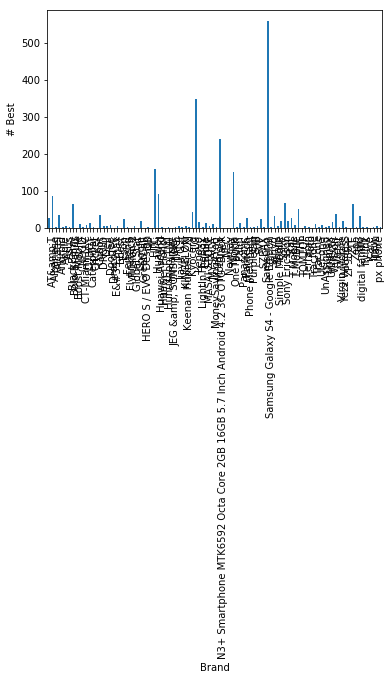

In [134]:
filt_res = res.copy()
filt_res['key'] = res['key'].map(lambda x: 1 if x == 1 else 0)
res_group = filt_res.groupby('brand').agg({'key': 'sum'})
brand_hist = res_group.plot.bar()
brand_hist.legend().set_visible(False)
brand_hist.set_xlabel('Brand')
brand_hist.set_ylabel('# Best')
plt.show()

In [135]:
res_group.sort_values(by = 'key', ascending=False).head(10)

,key
brand,
Samsung,559
LG,347
Motorola,240
HTC,158
Nokia,152
Huawei,91
AT&amp;T,87
Sony,68
ZTE,64


##### Co-occurence matrix

In [71]:
# build co-occurence matrix with a set
bought_occ = pd.DataFrame(brands_clique_set, columns = ['brand'])
bought_occ = bought_occ.set_index('brand')
for b in brands_clique_set:
    bought_occ[b] = 0
bought_occ.index.rename('# is preferred over ->', inplace = True)

occ_res = res.copy()
occ_res['key'] = occ_res['key'].map(lambda x: 1 if x == 1 else 0)
res_group = occ_res.groupby('id')

for c_id, c in res_group:
    winner_brand = c[c.key == 1].brand
    loser_brands = c[c.key == 0].brand
    for lb in loser_brands:
        bought_occ.loc[winner_brand, lb] += 1
        bought_occ.loc[lb, winner_brand] -= 1

#brand_data
print("Table dimension: ", bought_occ.shape)
bought_occ = bought_occ.loc[(bought_occ.sum(axis=1) != 0), (bought_occ.sum(axis=0) != 0)]
bought_occ

Table dimension:  (99, 99)


,,AT&amp;T,Albanese,Android,Apple,Asus,BlackBerry,Bolo Brands,Boost Mobile,CNPGD,...,ZP980+,ZTE,Zopo,blu,digital family,flylink,icare,inew,jiayu,px phone
# is preferred over ->,,,,,,,,,,,,,,,,,,,,,
,0,-2,-1,2,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
AT&amp;T,2,0,-1,0,12,0,13,0,0,0,...,0,1,0,0,0,0,-1,0,0,0
Albanese,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Android,-2,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
Apple,0,-12,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Asus,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BlackBerry,0,-13,0,0,0,0,0,0,-1,0,...,0,4,0,-4,0,0,0,0,0,0
Bolo Brands,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
Boost Mobile,0,0,0,0,0,0,1,0,0,0,...,0,-2,0,0,0,0,0,0,0,0


In [72]:
brand = "Samsung"
bought_occ.loc[brand, bought_occ.loc[brand] != 0]

                                     -10
AT&amp;T                               8
Apple                                 -3
BlackBerry                             1
Caterpillar                           -1
Dell                                   3
E&#39;max                             -3
Google                                -1
HTC                                   27
Huawei                               -11
Huawei Ascend                          2
Kyocera                                2
LG                                    80
MASAI STORE                           -1
MoneySaving4You                       -1
Motorola                             -25
NEC                                    1
Nokia                                -31
Pantech                               15
S lll                                 -4
Samsung Galaxy S4 - Google Edition    -3
Sanyo                                  6
Simple Mobile                          9
Sony                                 -34
Sony Ericsson   

# Unified statistics

In [167]:
u_df = pd.DataFrame(g.records)
features = ['fan_in', 'price', 'num_reviews', 'average_rating']

data = []
# works only with dim = 2
dim_cliques = 2

# auxiliary statistics
clique_count = 0
valid_clique_count = 0
# clique id
clique_id = 0
for c in cliques:
    # check dimension
    if len(c) != dim_cliques:
        continue
    # check all different brands in clique
    clique_count += 1
    brand_check = u_df['brand'].loc[c]
    if len(list(set(brand_check))) < dim_cliques:
        #pass
        continue
    valid_clique_count += 1
    #print(brand_check)
    df_tmp = pd.DataFrame()
    for f in features:
        # lower value means higher rank
        if f == 'price':
            clique_ranked = u_df[f].loc[c].rank(method='average', ascending = False)
        # higher value means higher rank
        else:
            clique_ranked = u_df[f].loc[c].rank(method='average')
        # remove bias (NB: on 2d cliques ONLY)
        if clique_ranked.values[0] == 1.5 or clique_ranked.values[1] == 1.5:
            continue
        df_tmp[f] = clique_ranked
    df_tmp['title'] = u_df['title'].loc[c]
    df_tmp['brand'] = u_df['brand'].loc[c]
    df_tmp['id'] = clique_id
    clique_id += 1
    data.append(df_tmp)
unified_df = pd.concat(data)
print("Number of cliques used:", len(res)/dim_cliques)
unified_df.head(100)

Number of cliques used: 2607.0


,average_rating,brand,fan_in,id,num_reviews,price,title
0,1.0,HTC,1.0,0,1.0,1.0,HTC HD2 T8585 Unlocked Phone with Touch Screen...
3173,2.0,Nokia,2.0,0,2.0,2.0,Nokia Lumia 520 8GB Unlocked GSM Windows 8 OS ...
4,1.0,Samsung,1.0,1,1.0,2.0,Samsung I9250 Galaxy Nexus Unlocked Phone with...
3272,2.0,Motorola,2.0,1,2.0,1.0,Motorola Moto G - Global GSM - Unlocked - 16GB...
5,2.0,SVP,1.0,2,1.0,2.0,2.8&quot; Dual SIM Quadband SVP Q70 Black Touc...
153,1.0,LG,2.0,2,2.0,1.0,LG GT550 Encore Unlocked Phone with 3MP Camera...
5,2.0,SVP,1.0,3,1.0,2.0,2.8&quot; Dual SIM Quadband SVP Q70 Black Touc...
2609,1.0,LG,2.0,3,2.0,1.0,LG Prime GS390 Unlocked Phone with Touchscreen...
7,1.0,Samsung,1.0,4,1.0,1.0,Samsung Galaxy Ace S5831 - Factory Unlocked GS...
3173,2.0,Nokia,2.0,4,2.0,2.0,Nokia Lumia 520 8GB Unlocked GSM Windows 8 OS ...


In [174]:
feat_agg = {}
for f in features:
    feat_agg[f] = 'sum'

filt_res = unified_df.copy()
for f in features:
    filt_res[f] = unified_df[f].map(lambda x: 1 if x == 1 else 0)
res_group = filt_res.groupby('brand').agg(feat_agg)
res_group.sort_values(by = 'fan_in', ascending=False).head(15)

# brand_hist = res_group.plot.bar()
# brand_hist.legend().set_visible(False)
# brand_hist.set_xlabel('Brand')
# brand_hist.set_ylabel('# Best')
# plt.show()

,fan_in,price,num_reviews,average_rating
brand,,,,
Samsung,559,561,565,508
LG,347,327,350,393
Motorola,240,244,221,268
HTC,158,198,151,199
Nokia,152,142,155,163
Huawei,91,76,89,51
AT&amp;T,87,71,85,68
Sony,68,49,65,49
ZTE,64,65,70,52


##### Co occurence matrices

In [180]:
features = ['fan_in', 'price', 'num_reviews', 'average_rating']
#feature = 'num_reviews'
occ_matrices = []
for feature in features:
    # build co-occurence matrix with a set
    unified_occ = pd.DataFrame(brands_clique_set, columns = ['brand'])
    unified_occ = unified_occ.set_index('brand')
    for b in brands_clique_set:
        unified_occ[b] = 0
    unified_occ.index.rename('# wins over ->', inplace = True)

    occ_res = res.copy()
    occ_res[feature] = occ_res[feature].map(lambda x: 1 if x == 1 else 0)
    res_group = occ_res.groupby('id')

    for c_id, c in res_group:
        winner_brand = c[c[feature] == 1].brand
        loser_brands = c[c[feature] == 0].brand
        for lb in loser_brands:
            unified_occ.loc[winner_brand, lb] += 1
            unified_occ.loc[lb, winner_brand] -= 1
    occ_matrices.append(unified_occ)

In [184]:
unified_occ = occ_matrices[0]
print("Table dimension: ", unified_occ.shape)
unified_occ = unified_occ.loc[(unified_occ.sum(axis=1) != 0), (unified_occ.sum(axis=0) != 0)]
unified_occ

Table dimension:  (99, 99)


,,AT&amp;T,Albanese,Android,Apple,Asus,BlackBerry,Bolo Brands,Boost Mobile,CNPGD,...,ZP980+,ZTE,Zopo,blu,digital family,flylink,icare,inew,jiayu,px phone
# wins over ->,,,,,,,,,,,,,,,,,,,,,
,0,-2,-1,2,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
AT&amp;T,2,0,-1,0,12,0,13,0,0,0,...,0,1,0,0,0,0,-1,0,0,0
Albanese,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Android,-2,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
Apple,0,-12,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Asus,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BlackBerry,0,-13,0,0,0,0,0,0,-1,0,...,0,4,0,-4,0,0,0,0,0,0
Bolo Brands,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
Boost Mobile,0,0,0,0,0,0,1,0,0,0,...,0,-2,0,0,0,0,0,0,0,0


Compare a brand with the others (the higher is a value, the better is such brands compared to the other ones)

In [196]:
brand = "LG"
compare_brand = pd.DataFrame()
for f,m in zip(features, occ_matrices):
    compare_brand[f] = m.loc[brand, m.loc[brand] != 0]
    
compare_brand

,fan_in,price,num_reviews,average_rating
,-7,-4.0,-6.0,NaN
AT&amp;T,3,3.0,3.0,-1.0
Alcatel,-3,5.0,-5.0,-1.0
Apple,1,1.0,1.0,-1.0
BlackBerry,2,1.0,2.0,-6.0
Boost Mobile,1,3.0,-1.0,1.0
Cubot,-1,-1.0,-1.0,1.0
Dell,1,1.0,1.0,-1.0
Doogee,-1,-1.0,-1.0,-1.0
Google,-1,-7.0,-1.0,7.0


# OLD Brand analysis

#### Find brands in cliques

In [ ]:
brands = []
dimension_min = 2

for c in cliques:
    if len(c) < dimension_min:
        continue
    for i in c:
        if 'brand' in g.records[i]:
            brands.append(g.records[i]['brand'])
            
print(str(len(brands)) + " products are associated to a brand.")
brands_set= sorted(set(brands))
print("There are " + str(len(brands_set)) + " brands in cliques.")
print(brands_set)

In [ ]:
brand_data = pd.DataFrame(brands_set, columns = ['brand'])
#brand_data = brand_data.replace("", "Empty")
brand_data = brand_data.set_index('brand')
#brand_data = brand_data.loc[brand_data['most sold'] > 10]

brand_data.sort_index().head()

#### Find most sold brand in each clique according to sale rank

In [ ]:
brand_data['most sold'] = 0

for c in cliques:
    # check cliques have min dimension
    if len(c) < dimension_min:
        continue
    # check brand is different for each product
    brand_check = []
    for i in c:
        brand_check.append(records[i]['brand'])
    if len(list(set(brand_check))) < len(c):
        continue
    # check sale rank category is the same for every article
    checkCat = []
    for i in c:
        checkCat.append(records[i]['salesRankCat'])
    if len(set(checkCat)) != 1:
        continue
    # min sale rank
    sr_min = min([records[i]['salesRankPos'] for i in c])
    # most sold products (some products may have the same rate)
    most_sold = [i for i in c if records[i]['salesRankPos'] == sr_min]
    # check that not every product is most sold
    if len(most_sold) < len(c):
    # increment most sold brands
        for i in most_sold:
            brand_data.loc[records[i]['brand'], 'most sold'] += 1
            

#### Find most rated brand in each clique according to avg rate

In [ ]:
brand_data['most rated'] = 0

for c in cliques:
    # check cliques have min dimension
    if len(c) < dimension_min:
        continue
    # check brand is different for each product
    brand_check = []
    for i in c:
        brand_check.append(records[i]['brand'])
    if len(list(set(brand_check))) < len(c):
        continue
    # max rating
    r_max = max([records[i]['average_rating'] for i in c])
    # most rated products (some products may have the same rate)
    most_rate = [i for i in c if records[i]['average_rating'] == r_max]
    # check that there is at least a product less rated than the others
    if len(most_rate) < len(c):
    # increment most rated brands
        for i in most_rate:
            brand_data.loc[records[i]['brand'], 'most rated'] += 1


#### Find  most expensive and cheapest brand in each clique 

In [77]:
brand_data['cheapest'] = 0
brand_data['most expensive'] = 0

for c in cliques:
    # check cliques have min dimension
    if len(c) < dimension_min:
        continue
    # check brand is different for each product
    brand_check = []
    for i in c:
        brand_check.append(records[i]['brand'])
    if len(list(set(brand_check))) < len(c):
        continue
    # max and min price
    p_max = max([records[i]['price'] for i in c])
    p_min = min([records[i]['price'] for i in c])
    # most expensive products (some products may have the same price)
    most_exp = [i for i in c if records[i]['price'] == p_max]
    # check that there is at least a product cheaper than the others
    if len(most_exp) < len(c):
    # increment most expensive brands
        for i in most_exp:
            brand_data.loc[records[i]['brand'], 'most expensive'] += 1
    # cheapest products (some products may have the same price)
    cheap = [i for i in c if records[i]['price'] == p_min]
    # check that there is at least a product more expensive than the others
    if len(cheap) < len(c):
    # increment cheapest brands
        for i in cheap:
            brand_data.loc[records[i]['brand'], 'cheapest'] += 1
            

#### Find most sold brand in each clique according to fan in

In [78]:
brand_data['most bought'] = 0

for c in cliques:
    # check cliques have min dimension
    if len(c) < dimension_min:
        continue
    # check brand is different
    brand_check = []
    for i in c:
        brand_check.append(records[i]['brand'])
    if len(list(set(brand_check))) < len(c):
        continue
    # check max fan in
    v_max = max([fan_in[i] for i in c])
    most_bought = [i for i in c if fan_in[i] == v_max]
    # the products cannot be compared because they ALL have the same fan in
    if len(most_bought) == len(c):
        continue
    # however, if multiple products have same fan in and there are other products, the each of the former is incremented
    for i in most_bought:
        brand_data.loc[records[i]['brand'], 'most bought'] += 1
    

In [ ]:
# filter dataframe
#brand_data = brand_data.rename(index={'': 'empty'})
#brand_data = brand_data.loc[brand_data['most sold'] > 10]

brand_data.sort_index()

In [ ]:
print(brand_data.loc['Samsung'])
print(brand_data.loc['LG'])

#### "Co occurence" matrix

For each bran row, the brand column indicates how many time it lost in terms of fan in

In [80]:
print("Fan-in analysis (most bought).")
bought_occ = pd.DataFrame(brands_set, columns = ['brand'])
bought_occ = bought_occ.set_index('brand')
for b in brands_set:
    bought_occ[b] = 0
bought_occ.index.rename('most bought', inplace = True)
    
# auxiliary statistics
clique_count = 0
valid_clique_count = 0
for c in cliques:
    # check cliques have min dimension
    if len(c) < dimension_min:
        continue
    # check all different brands
    clique_count += 1
    brand_check = []
    for i in c:
        brand_check.append(records[i]['brand'])
    if len(list(set(brand_check))) < len(c):
        continue
    #print(brand_check)
    valid_clique_count += 1
    v_max = max([fan_in[i] for i in c])
    # if same fan in there is no best: eg (samsung, 4) (HP, 4) none of the two is incremented
    most_bought = [i for i in c if fan_in[i] == v_max]
    others = [i for i in c if fan_in[i] != v_max]
    for i in most_bought:
        for j in others:
            bought_occ.loc[records[i]['brand'], records[j]['brand']] += 1
    
    
#brand_data
print("Percentage of valid cliques: ", valid_clique_count/clique_count)
print("Table dimension: ", bought_occ.shape)
#bought_occ

Fan-in analysis (most bought).
Percentage of valid cliques:  0.1375
Table dimension:  (20, 20)


In [81]:
# filter table
bought_occ = bought_occ.loc[(bought_occ.sum(axis=1) != 0), (bought_occ.sum(axis=0) != 0)]
#bought_occ.drop(["", "Unknown"], inplace=True, axis=1)
#bought_occ.drop(["", "Unknown"], inplace=True, axis=0)
#bought_occ.loc['Samsung']
bought_occ

,Canon,Focus Camera,Nikon,Olympus,Pentax
most bought,,,,,
Canon,0,1,1,0,0
Focus Camera,1,0,0,0,0
Kodak,0,0,0,2,0
Nikon,0,1,0,0,0
Ricoh,0,0,0,0,1


In [ ]:
for b in bought_occ.index:
    #print('Brand: ', b, ' , other choices: ', bought_occ.loc[b, bought_occ.loc[b] != 0])
    print('Brand: ', b)
    print(bought_occ.loc[b, bought_occ.loc[b] != 0])
    print('------')


In [ ]:
b_dict = {}
for b in bought_occ.index:
    row = bought_occ.loc[b, bought_occ.loc[b] != 0]
    l = [(i, row[i]) for i in row.index]
    #print('Brand: ', b, ', alternatives: ', l)
    b_dict[b] = l

brand = 'Samsung'
print('Alternatives to: ', brand)
print(b_dict[brand], sum(list(map((lambda x: x[1]), b_dict[brand]))))